In [1]:
import pandas as pd
import pathlib
import seaborn as sns

from matplotlib import pyplot as plt
from pprint import pprint

from settings import (BASE_CSV_PATH, QUALTRICS_DROP_COLS, SKIP_COLS, 
                      MULTISELECT_COLS, AGREE_DISAGREE_COLS, IMPORTANCE_COLS, 
                      STANDARD_DUMMY_COLS, UTILITY_SCORE_COLS)

In [2]:
base_df = pd.read_csv(BASE_CSV_PATH)
base_df.shape

(675, 139)

Only 675 responses, I assume?

## Pre-processing functions

In [3]:
def drop_utility_question_columns(in_df):
    out_df = in_df.copy()
    util_cols = [c for c in in_df.columns if "(This leaves 1 choice" in c]
    return out_df.drop(labels = util_cols, axis = 1)

In [4]:
def create_multinational_column(in_df, op_column = "Where does your organization have offices", 
                                null_fill = ""):
    out_df = in_df.copy()
    out_df["is_multinational"] = out_df[op_column].fillna(null_fill)
    out_df["is_multinational"] = out_df.is_multinational.str.contains("Multi")
    out_df["is_multinational"] = out_df.is_multinational.astype(int)
    return out_df.drop(labels = op_column, axis = 1)

In [5]:
def create_executive_column(in_df, op_column = "What is your seniority level?", 
                                null_fill = ""):
    out_df = in_df.copy()
    out_df["is_executive"] = out_df[op_column].fillna(null_fill)
    out_df["is_executive"] = out_df.is_executive.str.contains("Exec")
    out_df["is_executive"] = out_df.is_executive.astype(int)
    return out_df.drop(labels = op_column, axis = 1)

In [6]:
def create_male_column(in_df, op_column = "What best describes your gender?", 
                                null_fill = ""):
    out_df = in_df.copy()
    out_df["is_male"] = out_df[op_column].fillna(null_fill)
    out_df["is_male"] = out_df.is_male.str.contains("Male")
    out_df["is_male"] = out_df.is_male.astype(int)
    return out_df.drop(labels = op_column, axis = 1)

In [7]:
def add_cluster_columns(in_df, op_column = "labels"):
    out_df = in_df.copy()
    out_df["clust_zeroAndOne"] = [1 if v in [0,1] else 0 for v in in_df[op_column]]
    out_df["clust_eight"] = [1 if v == 8 else 0 for v in in_df[op_column]]
    out_df["clust_sixAndNine"] = [1 if v in [6,9] else 0 for v in in_df[op_column]]
    return out_df.drop(labels = op_column, axis = 1)

In [8]:
def add_dummmies_to_df(in_df, col_to_code, coding_prefix, prefix_sep = "_"):
    ''' Will work for naively dropping levels where there's no specific meaning to
    the effect and it's just belonging to a category
    
    I may need to handle the 'agree - disagree' columns separately...
    '''
    level_count = in_df[col_to_code].nunique()
    if level_count < 3:
        print(f"\tColumn {col_to_code} only has {level_count} levels...")
        print(f"\tReturning unmodified df")
        return in_df
    dummy_df = pd.get_dummies(data = in_df[col_to_code], 
                              prefix = coding_prefix, 
                              prefix_sep = prefix_sep)
    dummy_cols = dummy_df.columns.tolist()
    drop_col_index = dummy_df.sum().argmin()
    drop_col = dummy_cols[drop_col_index]
    print(f"\tRemoving level {drop_col} from coding for {col_to_code}")
    dummy_df.drop(labels = drop_col, axis = 1, inplace = True)
    out_df = in_df.join(dummy_df, how = "inner")
    return out_df.drop(labels = col_to_code, axis = 1)

## Preprocessing Steps

**Remove columns that are component ingredients for the overall utility scores:** Any column with `(This leaves 1 choice` can be dropped off, just because these are the component ingredients for the overall utilities.

In [9]:
reg_df = drop_utility_question_columns(in_df = base_df)

In [10]:
reg_df.shape

(675, 96)

**Remove columns that you haven't figured out how to fully deal with yet**

In [11]:
for column_group in [QUALTRICS_DROP_COLS, SKIP_COLS, MULTISELECT_COLS, AGREE_DISAGREE_COLS, IMPORTANCE_COLS]:
    reg_df.drop(labels = column_group, axis = 1, inplace = True)

In [12]:
reg_df.shape

(675, 27)

**Use the functions above to create special columns for multinational, executive, and gender identity of response...**

In [13]:
reg_df = create_multinational_column(in_df = reg_df)
reg_df = create_executive_column(in_df = reg_df)
reg_df = create_male_column(in_df = reg_df)

In [14]:
reg_df.shape

(675, 27)

**Create dummy columns in your standardized way, only keeping an effect for the least frequent response of each type**

In [15]:
for code_column, prefix in STANDARD_DUMMY_COLS.items():
    reg_df = add_dummmies_to_df(in_df = reg_df, 
                                col_to_code = code_column,
                                coding_prefix = prefix)

	Removing level empFunc_Design from coding for Which business function best describes your core responsibility?
	Removing level bizSize_Sole proprietor from coding for What best describes your company size?
	Removing level buildCapability_I’m responsible for training people on a new software from coding for What best describes your role in building capabilities within your organization?  Select the most relevant.
	Removing level bizStrategy_Other from coding for Which of the following statements best describes your company’s strategy today?
	Removing level budgetCategory_Other from coding for What type of budget might you use for a solution similar to that of the concept "Learn While Doing?" - Selected Choice
	Removing level purchaseRole_I’d approve the purchase for my entire organization from coding for What would best describe your involvement in the purchase process of a solution similar to that of the concept "Learn While Doing?"
	Removing level empAge_18-21 from coding for What is

In [16]:
reg_df.shape

(675, 80)

**Create custom columns for the clusters that Nathan and Isabella specified:** this uses and then gets rid of the `label` column

In [17]:
reg_df = add_cluster_columns(in_df = reg_df)

In [18]:
reg_df.shape

(675, 82)

**Finally, drop out people with a `fit_statistic` lower than 0.39:** Apparently this is what sawtooth recommends when looking at utilities. I also think that Alla may have already taken this step when creating this file...

In [19]:
reg_df = reg_df.loc[(reg_df["Fit Statistic"] > 0.39)]
reg_df.drop(labels = "Fit Statistic", axis = 1, inplace = True)
reg_df.shape

(675, 81)

**OK,** so the only extraneous columns at this point are the value prop columns related to the target.

In [20]:
pprint(reg_df.columns.tolist())

["Equip your workforce with modern skills while solving your organization's "
 'top strategic challenges',
 'Build new capabilities while doing the work that matters to your team',
 "Hone your team's ability to continually experiment and build on the "
 'resulting knowledge',
 'Equip teams with the tools and mindset to solve problems independently',
 'Stay ahead of industry disruption by fostering an agile, resilient '
 'organizational culture',
 'Lead your organization through a digital transformation',
 'Cultivate shared processes and mindsets so your team can achieve better '
 'results',
 'Develop customer-centered skills to repeatedly build products, services, and '
 'experiences that appeal to your target audience',
 'Help employees develop customer-centered skills while working towards '
 'company strategy',
 'Scale new processes and methodologies across your organization with tools '
 'every team will find valuable',
 'is_multinational',
 'is_executive',
 'is_male',
 'empFunc_En

## Making a Target Variable

The only other features we may want to create are **which** of the 10 value propositions the person rated _most_ or _least_ desireable..

And which of those columns we want to keep depends on whether we're regressing against max utility or min utility.

In [21]:
max_utility_scores = reg_df[UTILITY_SCORE_COLS].max(axis = 1)
max_utility_scores.shape

(675,)

This is the target variable for the maximum utility score...

In [22]:
max_utility_scores.describe()

count    675.000000
mean      20.696342
std        1.873814
min       14.738210
25%       19.558480
50%       20.758560
75%       22.047345
max       25.626480
dtype: float64

In [23]:
util_score_df = reg_df[UTILITY_SCORE_COLS].copy()

In [24]:
max_utility_vps = util_score_df.idxmax(axis = 1)
max_utility_df = pd.DataFrame(data = max_utility_vps, columns = ["maxUtility"])
max_utility_df

,maxUtility
0,Help employees develop customer-centered skill...
1,Equip teams with the tools and mindset to solv...
2,Develop customer-centered skills to repeatedly...
3,Equip teams with the tools and mindset to solv...
4,Cultivate shared processes and mindsets so you...
...,...
670,Hone your team's ability to continually experi...
671,Scale new processes and methodologies across y...
672,Develop customer-centered skills to repeatedly...
673,Develop customer-centered skills to repeatedly...


In [25]:
max_utility_df["maxUtility"].value_counts()

Develop customer-centered skills to repeatedly build products, services, and experiences that appeal to your target audience    124
Lead your organization through a digital transformation                                                                         119
Stay ahead of industry disruption by fostering an agile, resilient organizational culture                                        78
Hone your team's ability to continually experiment and build on the resulting knowledge                                          63
Help employees develop customer-centered skills while working towards company strategy                                           58
Equip teams with the tools and mindset to solve problems independently                                                           57
Equip your workforce with modern skills while solving your organization's top strategic challenges                               46
Scale new processes and methodologies across your organization with tools ev

In [26]:
max_utility_feats = add_dummmies_to_df(in_df = max_utility_df, col_to_code="maxUtility", coding_prefix="maxUtil")

	Removing level maxUtil_Build new capabilities while doing the work that matters to your team from coding for maxUtility


In [27]:
max_utility_feats.shape

(675, 9)

In [28]:
reg_df.shape

(675, 81)

In [29]:
len(UTILITY_SCORE_COLS)

10

So, the resulting `max_utility_feats` df should be 81 - 10 + 9 columns wide, or 80.

In [30]:
base_feat_cols = [c for c in reg_df.columns if c not in UTILITY_SCORE_COLS]
max_utility_feats = max_utility_feats.join(reg_df[base_feat_cols], how = "inner")

In [31]:
max_utility_feats.shape

(675, 80)

Basically repeating the process above with the minimum percentile score (... more for formality's sake ...)

In [38]:
min_utility_scores = reg_df[UTILITY_SCORE_COLS].min(axis = 1)
min_utility_scores.shape

(675,)

In [39]:
min_utility_vps = util_score_df.idxmin(axis = 1)
min_utility_df = pd.DataFrame(data = min_utility_vps, columns = ["minUtility"])
min_utility_feats = add_dummmies_to_df(in_df = min_utility_df, col_to_code="minUtility", coding_prefix="minUtil")
min_utility_feats = min_utility_feats.join(reg_df[base_feat_cols], how = "inner")

	Removing level minUtil_Scale new processes and methodologies across your organization with tools every team will find valuable from coding for minUtility


In [42]:
min_utility_feats.shape

(675, 80)

In [41]:
min_utility_df["minUtility"].value_counts()

Lead your organization through a digital transformation                                                                         180
Hone your team's ability to continually experiment and build on the resulting knowledge                                         104
Stay ahead of industry disruption by fostering an agile, resilient organizational culture                                        68
Help employees develop customer-centered skills while working towards company strategy                                           65
Cultivate shared processes and mindsets so your team can achieve better results                                                  60
Develop customer-centered skills to repeatedly build products, services, and experiences that appeal to your target audience     54
Build new capabilities while doing the work that matters to your team                                                            39
Equip your workforce with modern skills while solving your organization's to

## Trying a regression...

In [32]:
import statsmodels.api as sm

Adding a bias term here seems like a good idea...

In [34]:
max_utility_feats = sm.add_constant(max_utility_feats)

In [35]:
model = sm.OLS(max_utility_scores, max_utility_feats)

In [36]:
results = model.fit()

In [37]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     3.323
Date:                Wed, 01 Jul 2020   Prob (F-statistic):           6.05e-17
Time:                        17:27:14   Log-Likelihood:                -1256.3
No. Observations:                 675   AIC:                             2675.
Df Residuals:                     594   BIC:                             3040.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------

Accidentally running this without the bias term added yielded very different results(but admittedly less believable). It may be more useful in this case, but I would need to change variables a bit to **not** drop the k-1 variables. See [these nerds on cross validated](https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model#:~:text=If%20your%20response%20variable%20is,to%20leave%20the%20intercept%20in.&text=You%20can%20leave%20out%20the,or%20your%20residuals%20are%20biased.) for more details.

**TODO (?)**: experiment with this, because I don't think it would change most of your processing functions _that much?_

In [43]:
min_utility_feats = sm.add_constant(min_utility_feats)

model = sm.OLS(max_utility_scores, min_utility_feats)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.110
Date:                Wed, 01 Jul 2020   Prob (F-statistic):              0.252
Time:                        18:20:04   Log-Likelihood:                -1334.1
No. Observations:                 675   AIC:                             2830.
Df Residuals:                     594   BIC:                             3196.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------

## Future, maybe more productive directions?

**1. Do a different regression against something less abstract**

In [44]:
base_df["How interested would you be in this type of solution as a whole?"].value_counts()

Interested               299
Not very interested      152
Very interested          122
Not at all interested     69
Name: How interested would you be in this type of solution as a whole?, dtype: int64

In [45]:
pd.isnull(base_df["How interested would you be in this type of solution as a whole?"]).sum()

33

Also try this as an OR on the `Would You Invest in the Next Year?` Questions

I could do a logistic regression against a 0/1 version of this column, to understand how variables have an impact on someone's overall level of interest ...

**2. Rework the dummy coding scheme to keep all variable levels, then do interceptless regression -- PUNT**

**3. Try to regress against the other Sawtooth scores -- PUNT**

My least favorite option, because frankly we're still regressing against something kind of abstract

## Look at skill building frequency ...

In [61]:
from collections import Counter

In [59]:
skill_choice_col = "What skill building topics are most relevant to your team(s) today? Select the top 3. - Selected Choice"

In [60]:
base_df[skill_choice_col].value_counts()

Innovation,Business Strategy,Leadership for Organizational Impact                                  25
Business Strategy,Leadership for Organizational Impact,Developing customer-centered solutions      20
Innovation,Business Strategy,Digital Transformation                                                19
Innovation,Business Strategy,Product Design                                                        18
Innovation,Digital Transformation,Developing customer-centered solutions                           14
                                                                                                   ..
21st Century Skills (e.g. creativity, collaboration),Product Design,Service Design                  1
Presentation Skills,21st Century Skills (e.g. creativity, collaboration),Digital Transformation     1
Design Thinking,Digital Transformation,Other                                                        1
Design Thinking,Product Design,Developing customer-centered solutions             

In [62]:
base_df.at[674,skill_choice_col]

'Innovation,Design Thinking,Service Design'

I know this a unique identifier that can be used to join into a long dataframme where all of the three choices get their own row.

In [63]:
base_df.at[674, "Unnamed: 0"]

439

In [68]:
skill_choice_rows = []
for i in range(len(base_df)):
    join_key = base_df.at[i, "Unnamed: 0"]
    chosen_skills = base_df.at[i, skill_choice_col].replace(", ", ";")
    for skill in chosen_skills.split(","):
        row_dict = {"Unnamed: 0": join_key, "chosen_skill": skill}
        skill_choice_rows.append(row_dict)
skill_choice_df = pd.DataFrame(data = skill_choice_rows)

In [70]:
len(skill_choice_df) == (len(base_df) * 3)

True

In [72]:
skill_choice_df["Unnamed: 0"].nunique()

675

In [73]:
keep_cols = [c for c in base_df.columns if c not in UTILITY_SCORE_COLS]
skill_choice_df = skill_choice_df.merge(right = base_df[keep_cols], on = "Unnamed: 0")

In [74]:
skill_choice_df.shape

(2025, 130)

Text(0, 0.5, 'Times Selected')

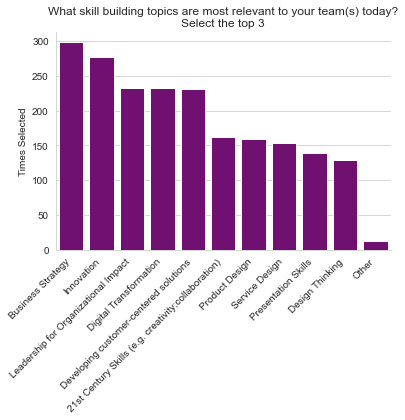

In [86]:
sns.set_style("whitegrid")

skill_sort = skill_choice_df["chosen_skill"].value_counts().sort_values(ascending = False).index.tolist()
sns.countplot(x = "chosen_skill",
              order = skill_sort,
              color = "purple",
              data = skill_choice_df)
plt.xticks(rotation = 45, ha = "right")
sns.despine()
plt.title("What skill building topics are most relevant to your team(s) today?\nSelect the top 3")
plt.xlabel("")
plt.ylabel("Times Selected")

Couple of basic counts on the data ...

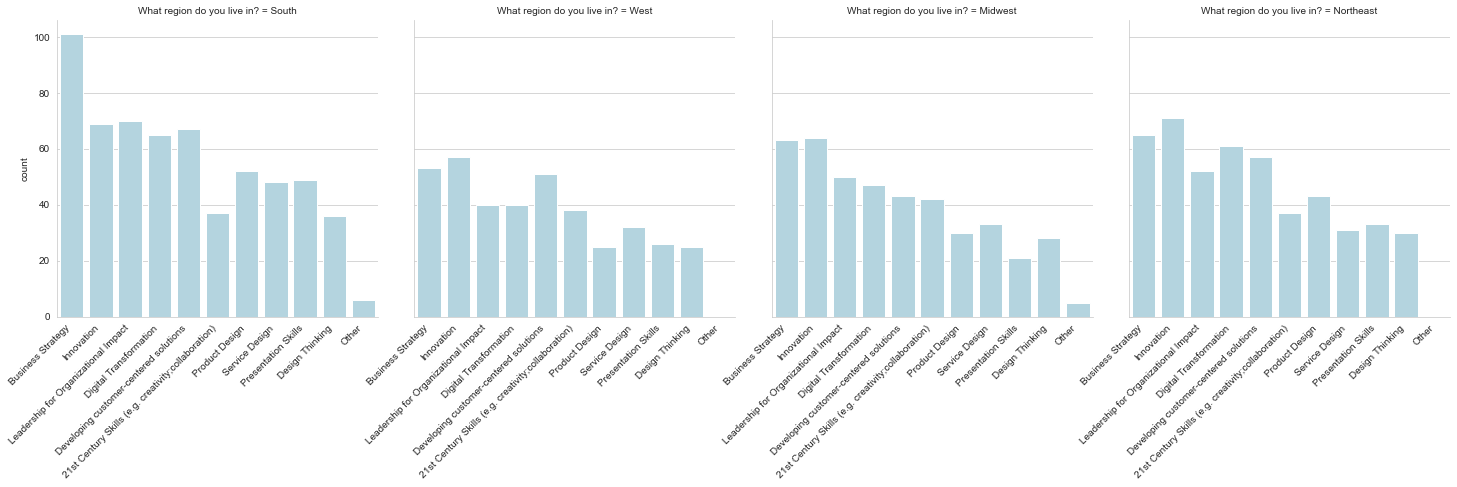

In [90]:
g = sns.catplot("chosen_skill", col="What region do you live in?", 
            col_wrap=4, data=skill_choice_df, kind="count", 
            color = "lightblue", order = skill_sort)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

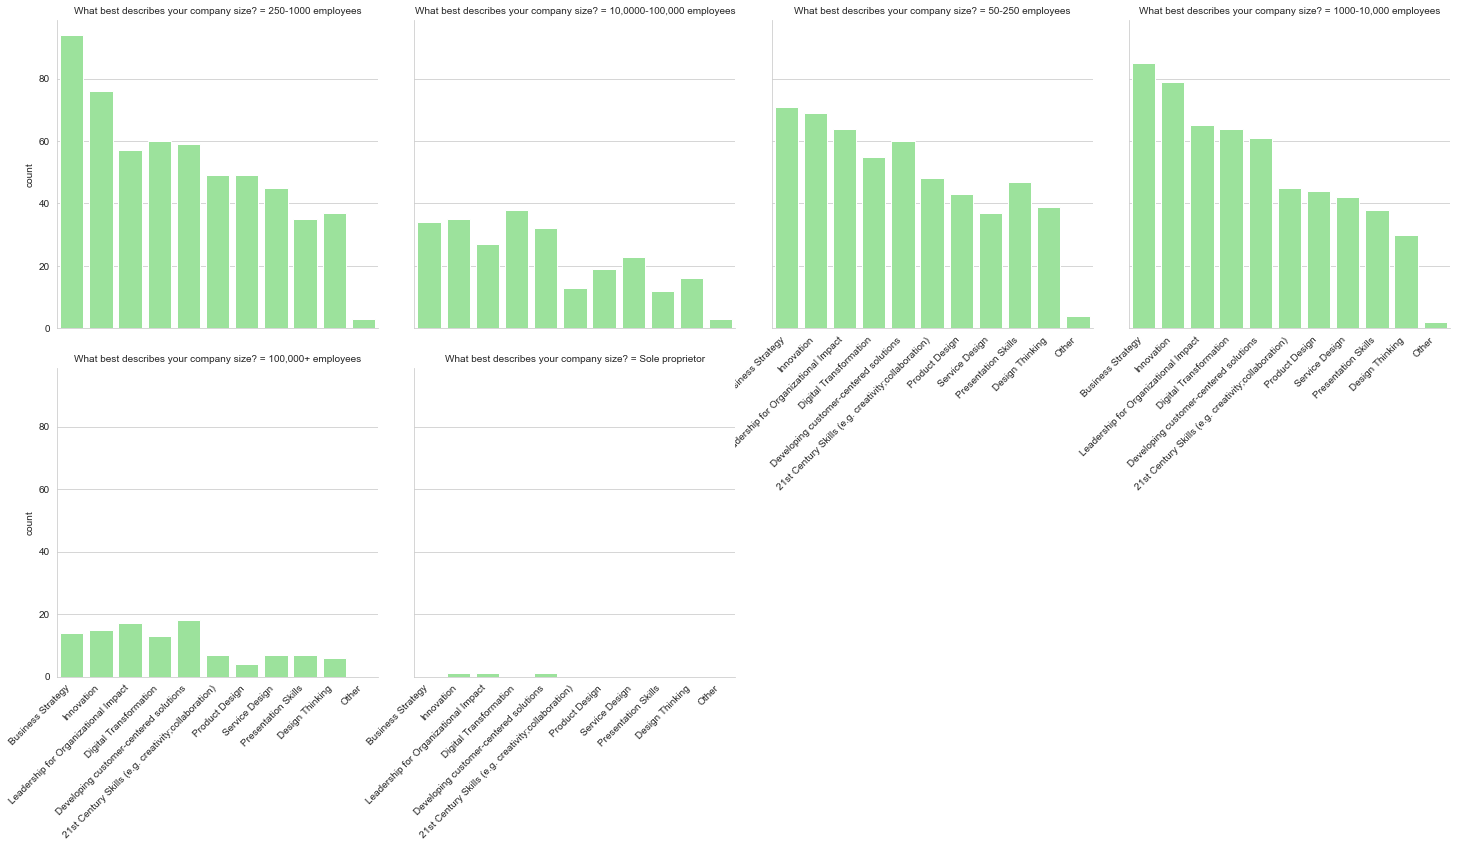

In [92]:
g = sns.catplot("chosen_skill", col="What best describes your company size?", 
            col_wrap=4, data=skill_choice_df, kind="count", 
            color = "lightgreen", order = skill_sort)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

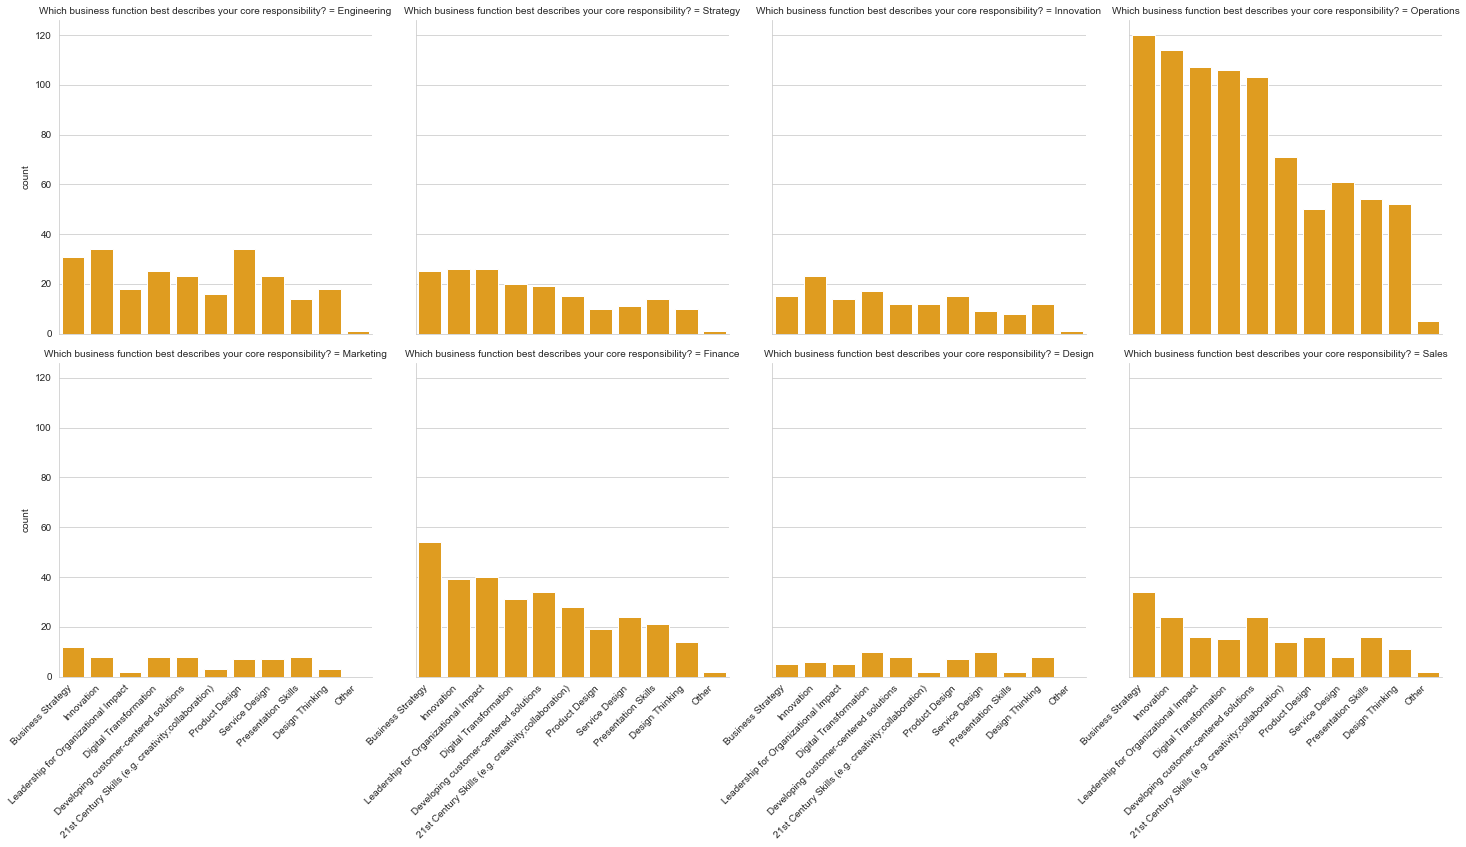

In [93]:
g = sns.catplot("chosen_skill", col="Which business function best describes your core responsibility?", 
            col_wrap=4, data=skill_choice_df, kind="count", 
            color = "orange", order = skill_sort)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

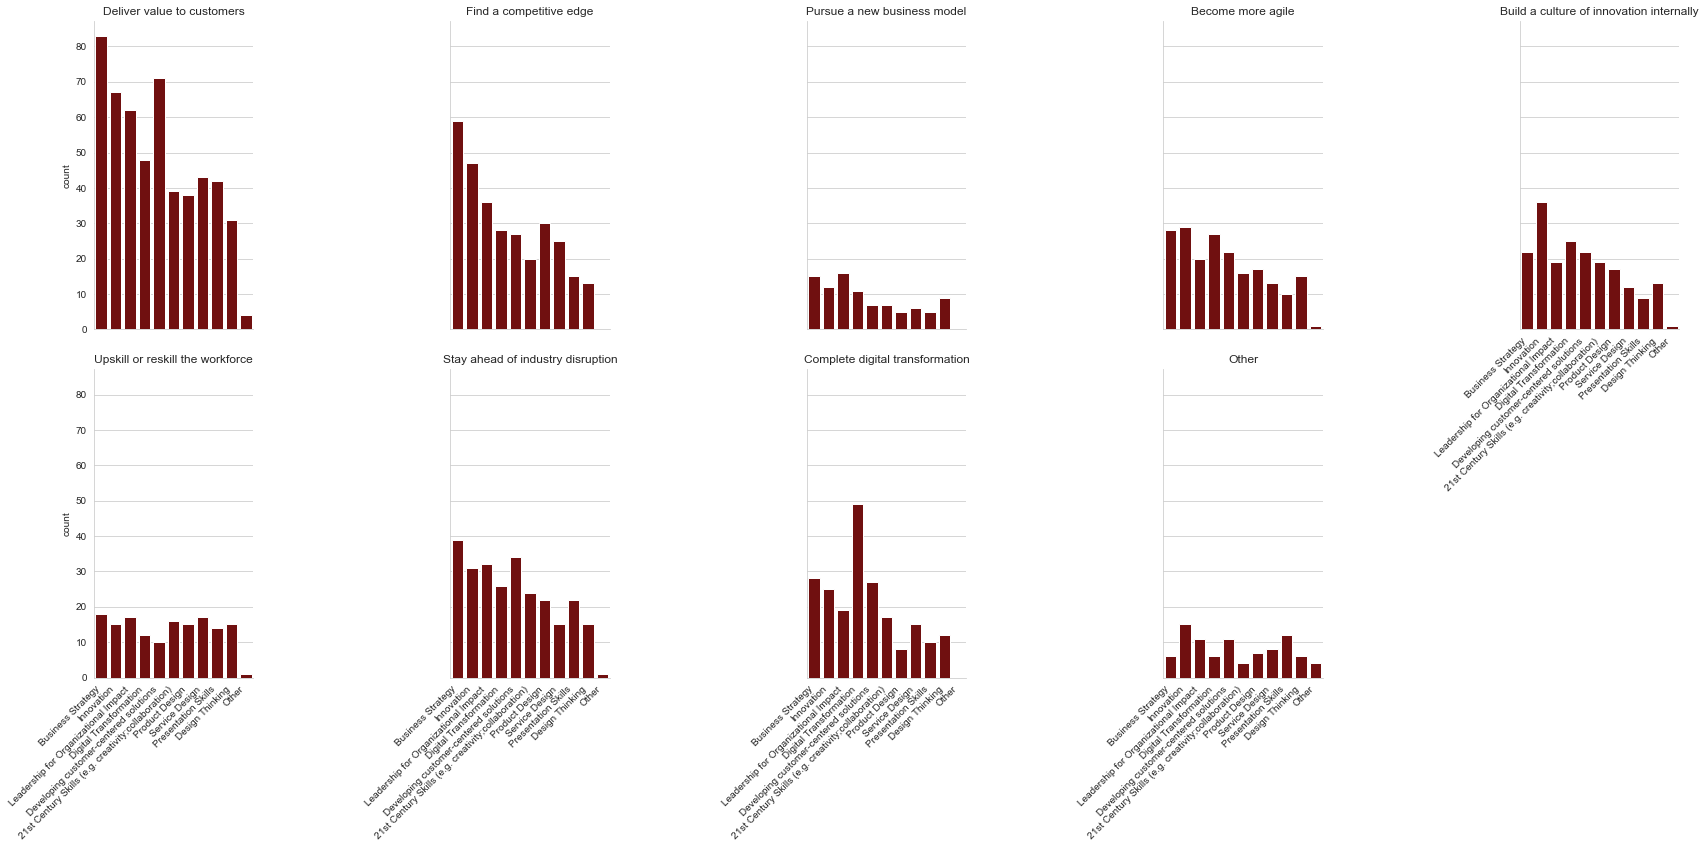

In [101]:
g = sns.catplot("chosen_skill", col="Which of the following statements best describes your company’s strategy today?", 
            col_wrap=5, data=skill_choice_df, kind="count", 
            color = "maroon", order = skill_sort)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")
    axes.set_title(axes.get_title().replace("Which of the following statements best describes your company’s strategy today? = ",""))

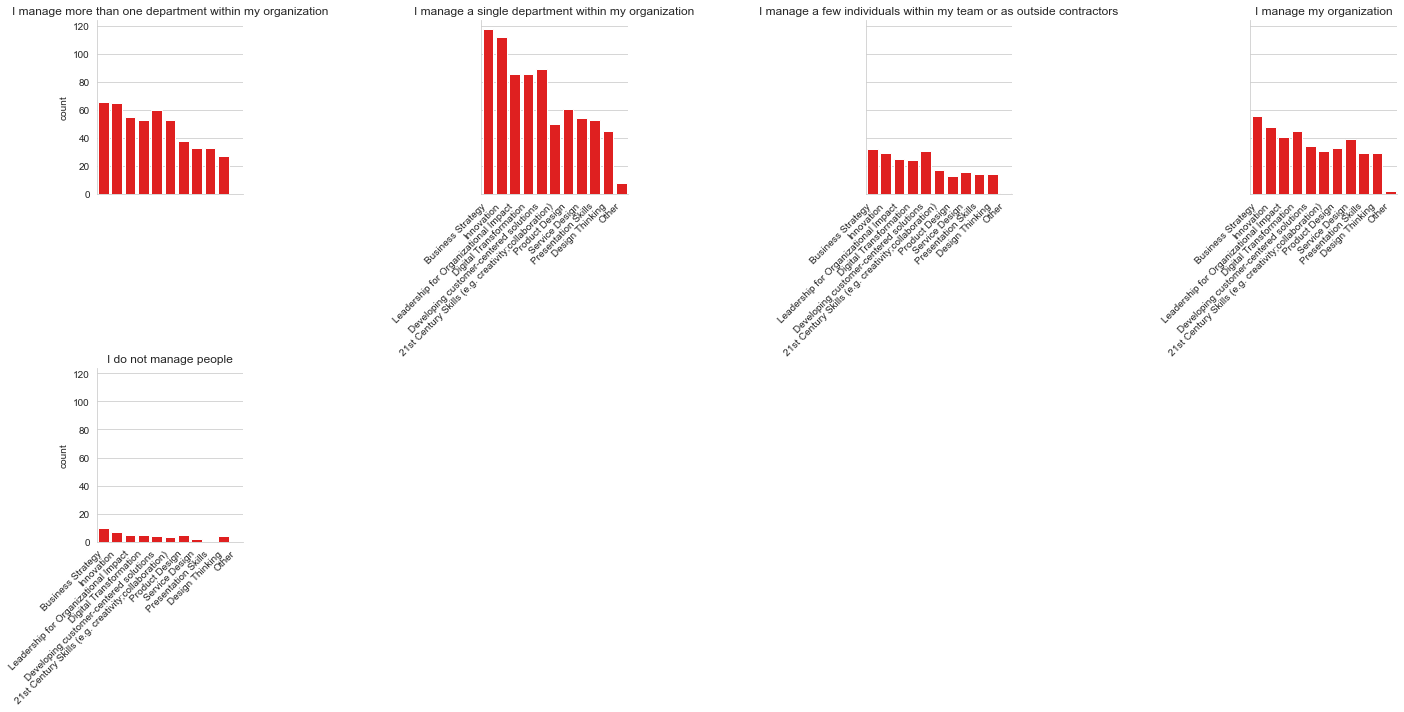

In [114]:
g = sns.catplot("chosen_skill", col="Which statement best describes your current management situation?", 
            col_wrap=4, data=skill_choice_df, kind="count", 
            color = "red", order = skill_sort)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")
    axes.set_title(axes.get_title().replace("Which statement best describes your current management situation? = ",""))
plt.tight_layout()

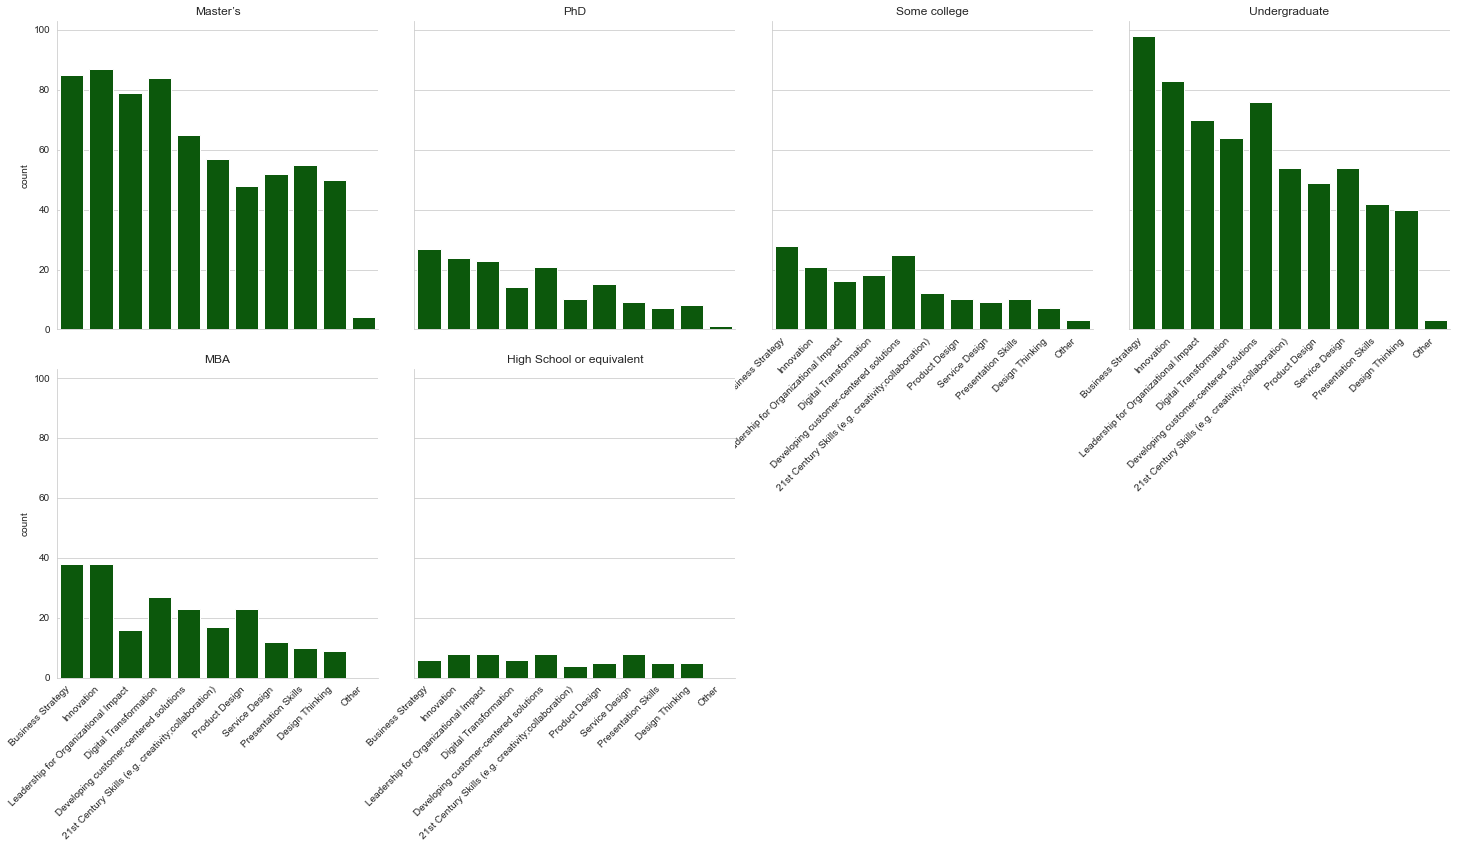

In [108]:
g = sns.catplot("chosen_skill", col="What best describes your highest level of education?", 
            col_wrap=4, data=skill_choice_df, kind="count", 
            color = "darkgreen", order = skill_sort)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")
    axes.set_title(axes.get_title().replace("What best describes your highest level of education? = ",""))

In [111]:
def cluster_labeller(v):
    if v in [0,1]:
        return "ZeroAndOne"
    if v in [6,9]:
        return "SixAndNine"
    if v == 8:
        return "Eight"
    return "AnotherCluster"

skill_choice_df["cluster"] = skill_choice_df["labels"].apply(cluster_labeller)

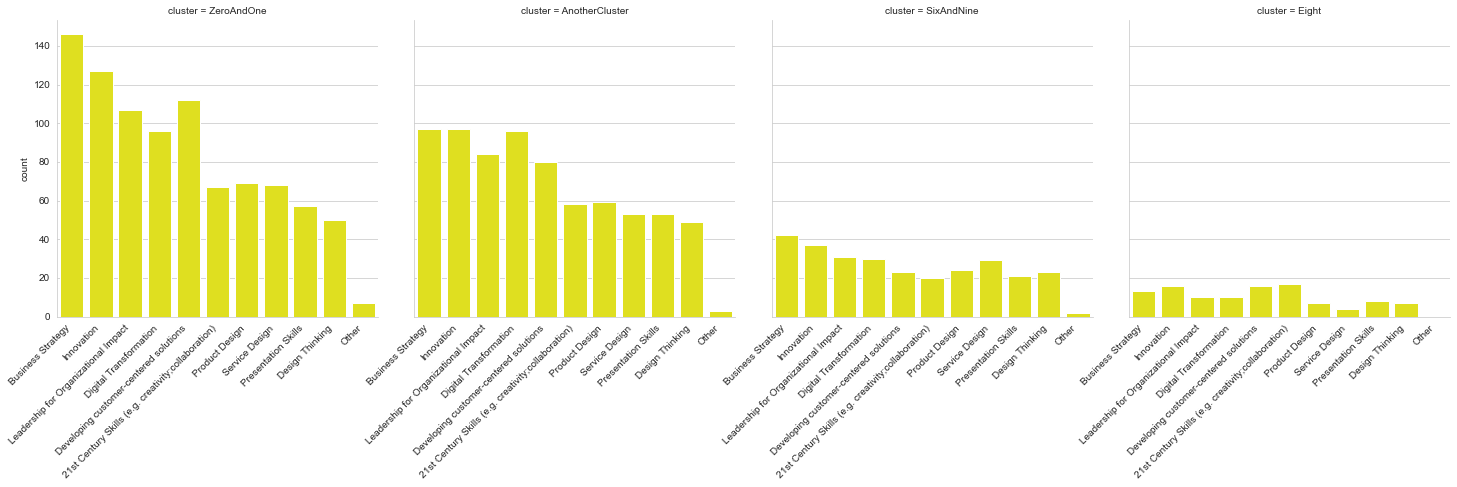

In [112]:
g = sns.catplot("chosen_skill", col="cluster", 
            col_wrap=4, data=skill_choice_df, kind="count", 
            color = "yellow", order = skill_sort)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

## Logistic regression against interest

In [115]:
interest_col = "How interested would you be in this type of solution as a whole?"
base_df[interest_col].value_counts()

Interested               299
Not very interested      152
Very interested          122
Not at all interested     69
Name: How interested would you be in this type of solution as a whole?, dtype: int64

In [116]:
base_df[interest_col].fillna(value = "Not very interested", inplace = True)

In [117]:
interest_order = ["Very interested", "Interested", "Not very interested", "Not at all interested"]

Text(0, 0.5, 'Frequency')

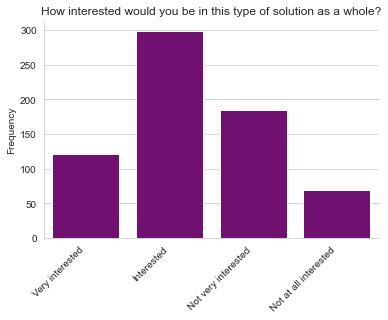

In [118]:
sns.countplot(x = interest_col,
              order = interest_order,
              color = "purple",
              data = base_df)
plt.xticks(rotation = 45, ha = "right")
sns.despine()
plt.title("How interested would you be in this type of solution as a whole?")
plt.xlabel("")
plt.ylabel("Frequency")

*Region doesn't really seem to matter that much*

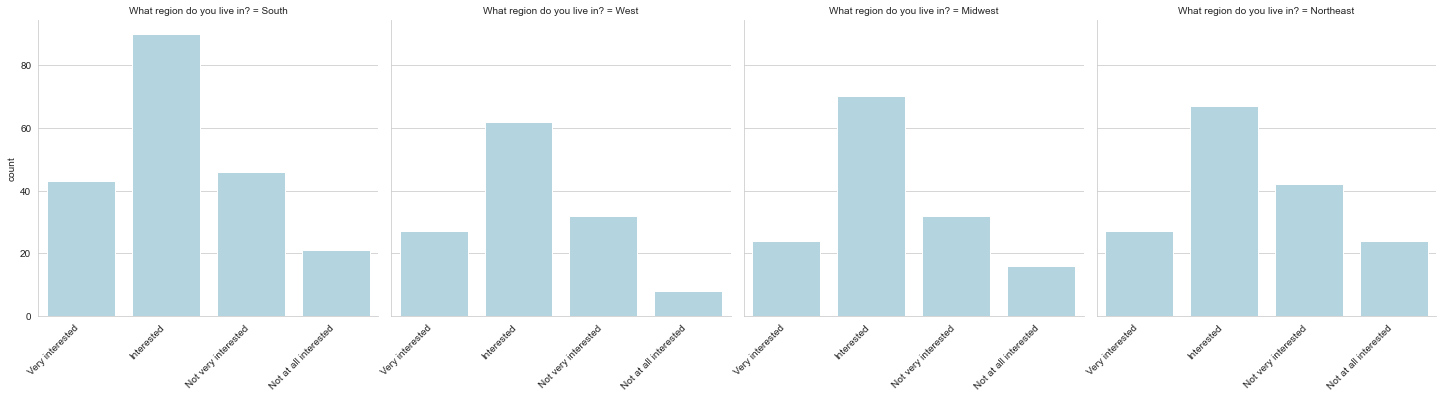

In [119]:
g = sns.catplot(interest_col, col="What region do you live in?", 
            col_wrap=4, data=base_df, kind="count", 
            color = "lightblue", order = interest_order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

*Same for company size, except it seems to be a bit less attractive (50-50 like/dislike) to really large companies*

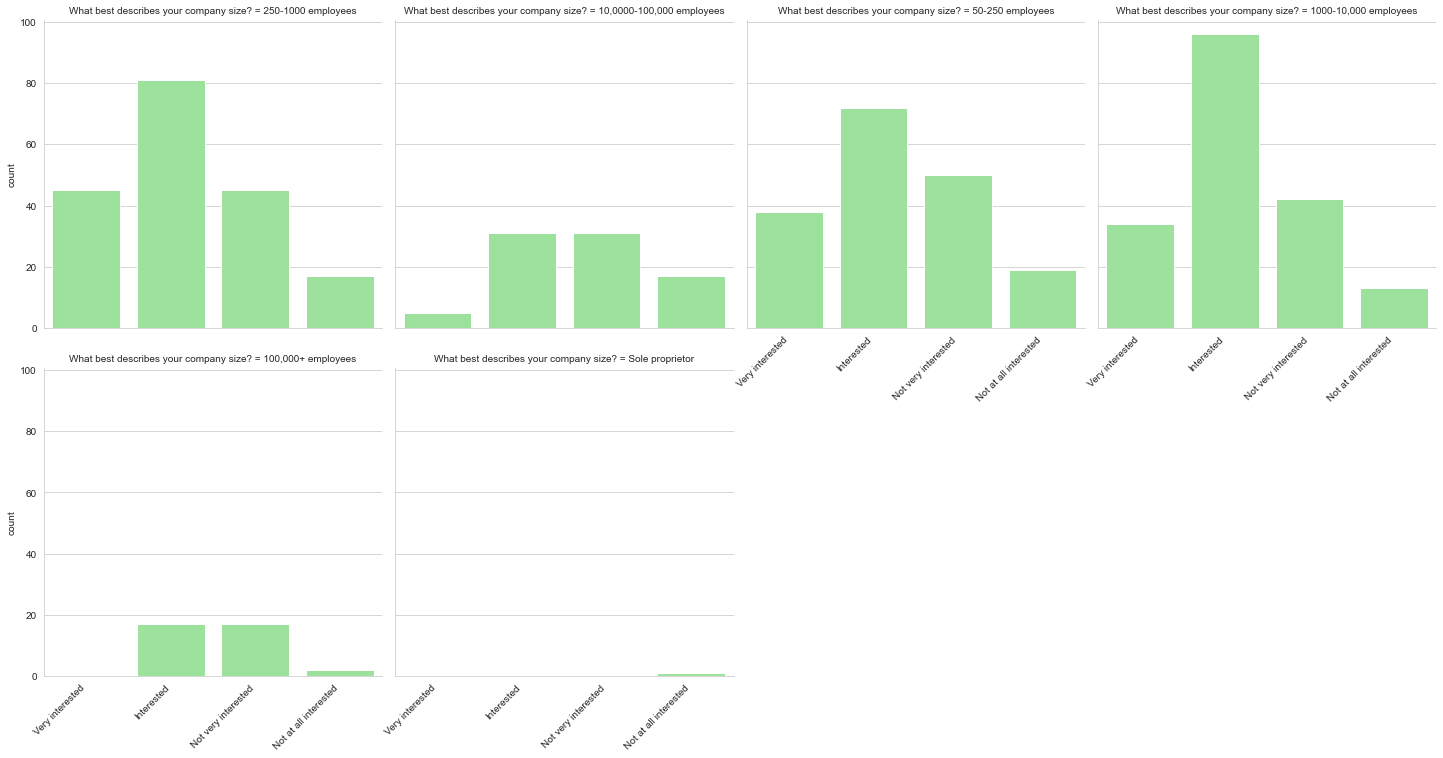

In [120]:
g = sns.catplot(interest_col, col="Which business function best describes your core responsibility?", 
            col_wrap=4, data=base_df, kind="count", 
            color = "lightgreen", order = interest_order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

*Seems that people who are in Engineering have a more pronounced skew to being interested, while Innovation, Sales, and Strategy are a bit more 50-50*

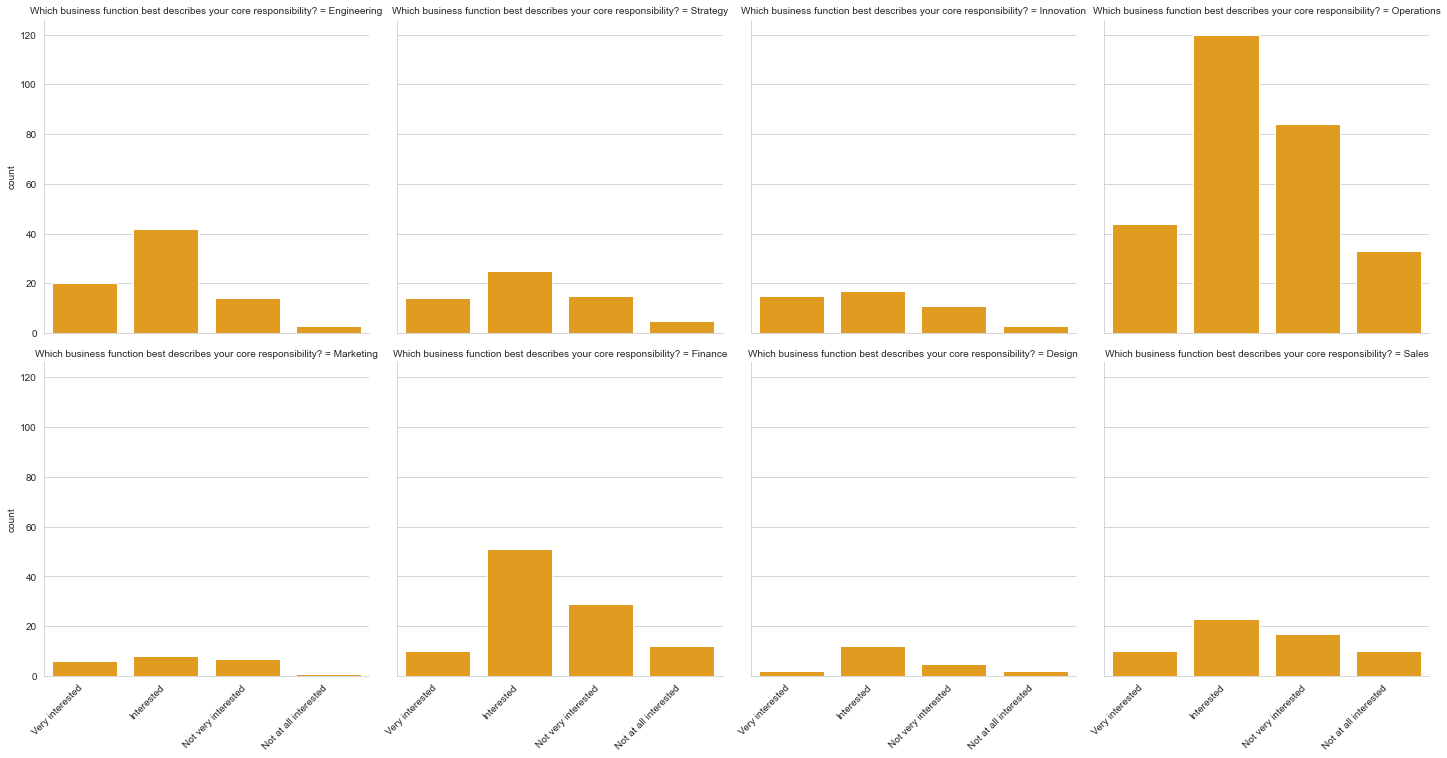

In [121]:
g = sns.catplot(interest_col, col="Which business function best describes your core responsibility?", 
            col_wrap=4, data=base_df, kind="count", 
            color = "orange", order = interest_order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

*Finding a competitive edge stands out as something where the interest balance seems to be a little bit more in favor of 2-1*

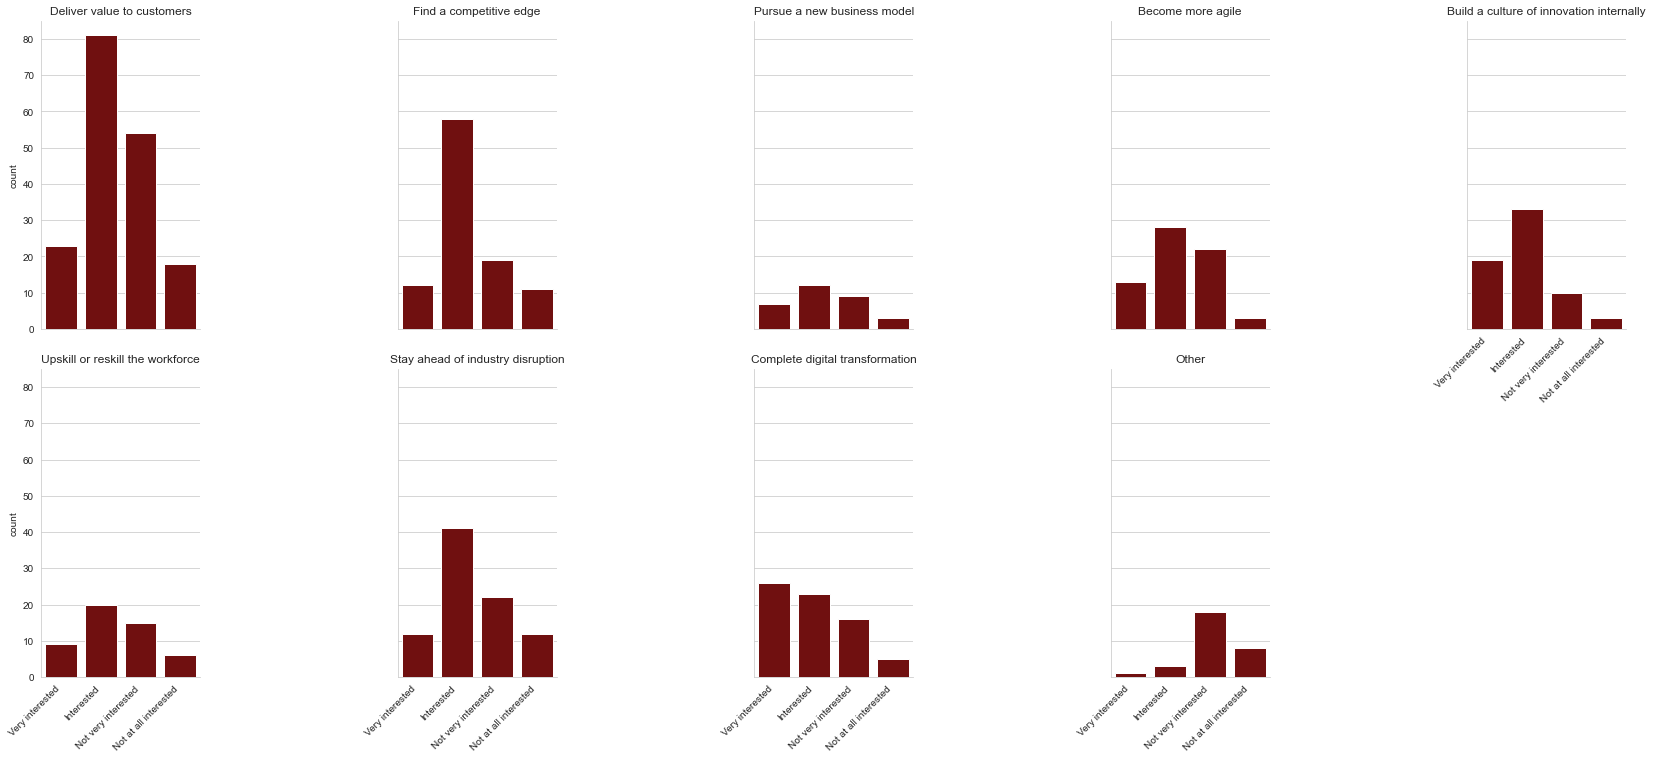

In [122]:
g = sns.catplot(interest_col, col="Which of the following statements best describes your company’s strategy today?", 
            col_wrap=5, data=base_df, kind="count", 
            color = "maroon", order = interest_order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")
    axes.set_title(axes.get_title().replace("Which of the following statements best describes your company’s strategy today? = ",""))

*It seems a bit like the more deparments you manage, the higher the ratio of interest to not interest is*

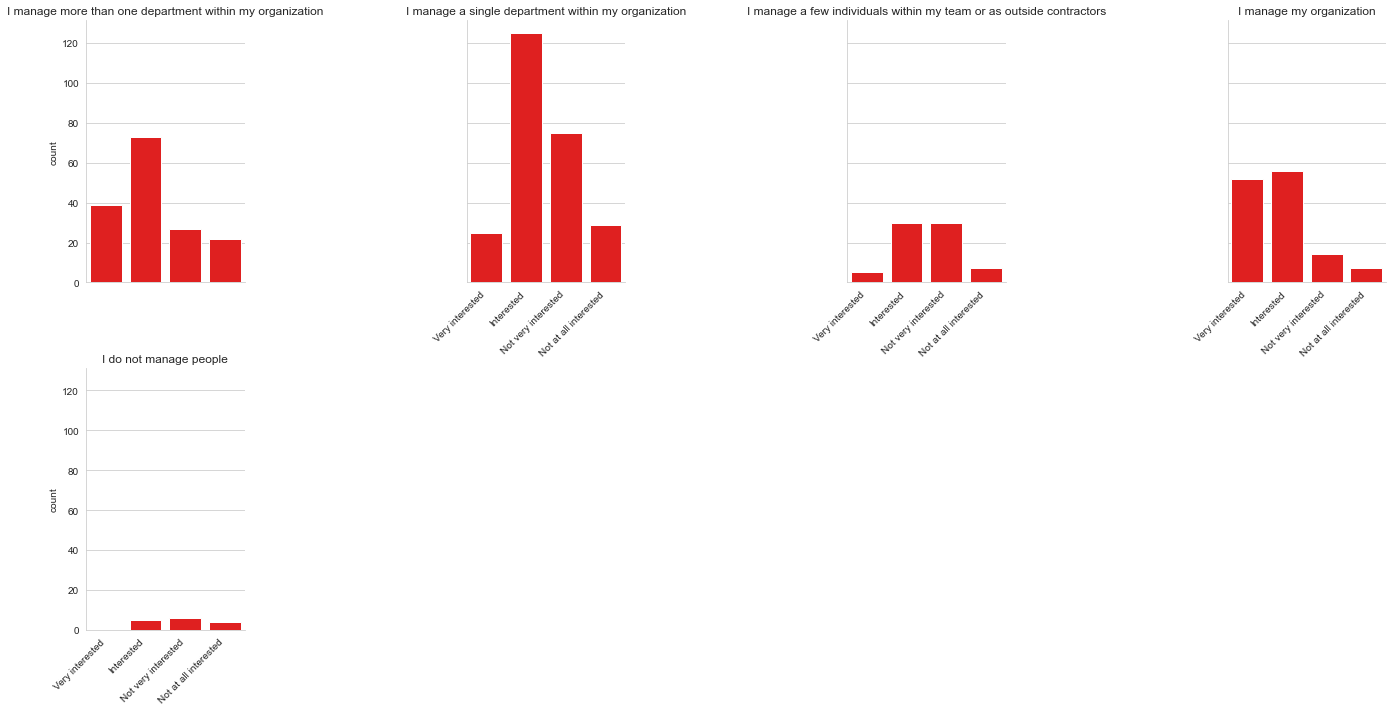

In [123]:
g = sns.catplot(interest_col, col="Which statement best describes your current management situation?", 
            col_wrap=4, data=base_df, kind="count", 
            color = "red", order = interest_order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")
    axes.set_title(axes.get_title().replace("Which statement best describes your current management situation? = ",""))
plt.tight_layout()

*Not too too much obvious jumping out here*

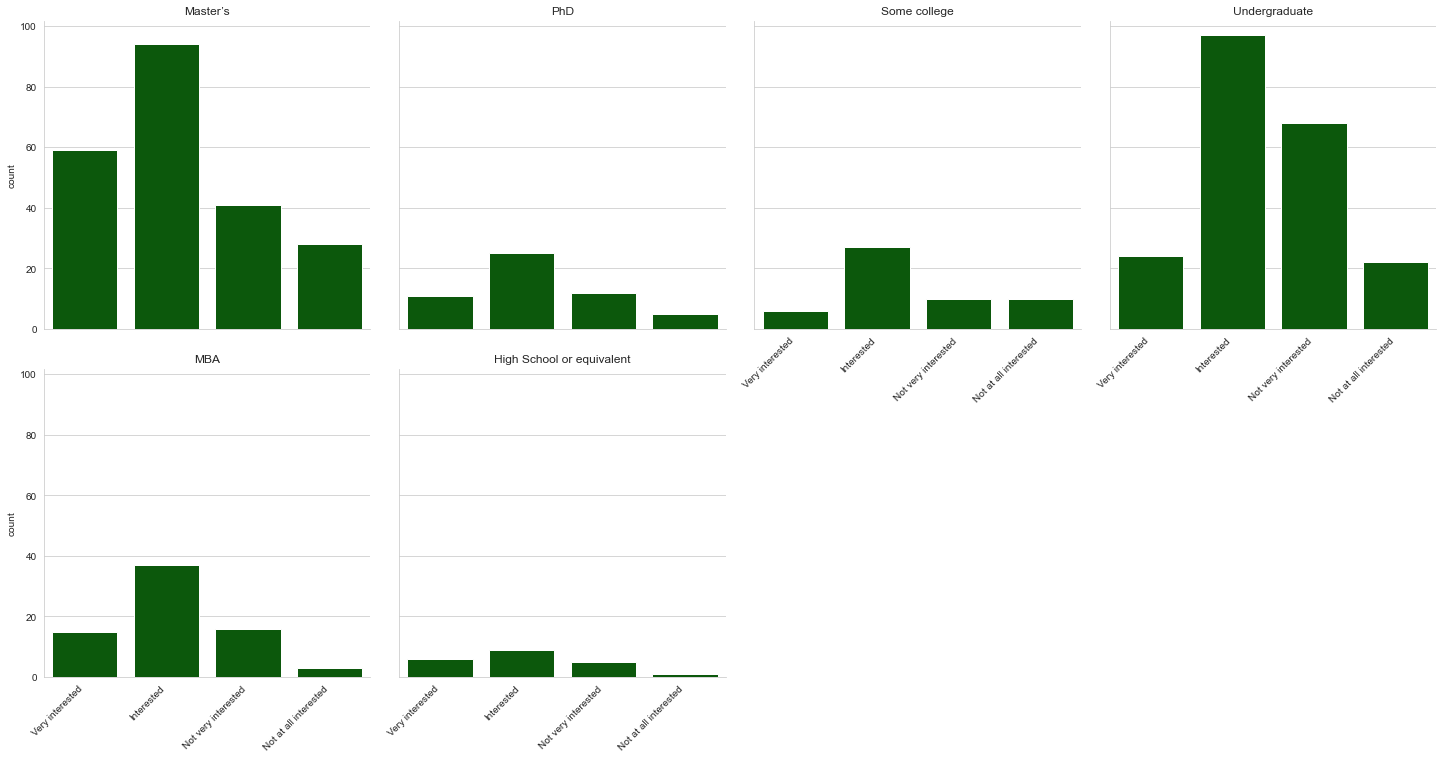

In [124]:
g = sns.catplot(interest_col, col="What best describes your highest level of education?", 
            col_wrap=4, data=base_df, kind="count", 
            color = "darkgreen", order = interest_order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")
    axes.set_title(axes.get_title().replace("What best describes your highest level of education? = ",""))

*Well then, the group with clusters SixAndNine and cluster Eight are smaller audiences, but they are pretty uniformly in favor of the concept*

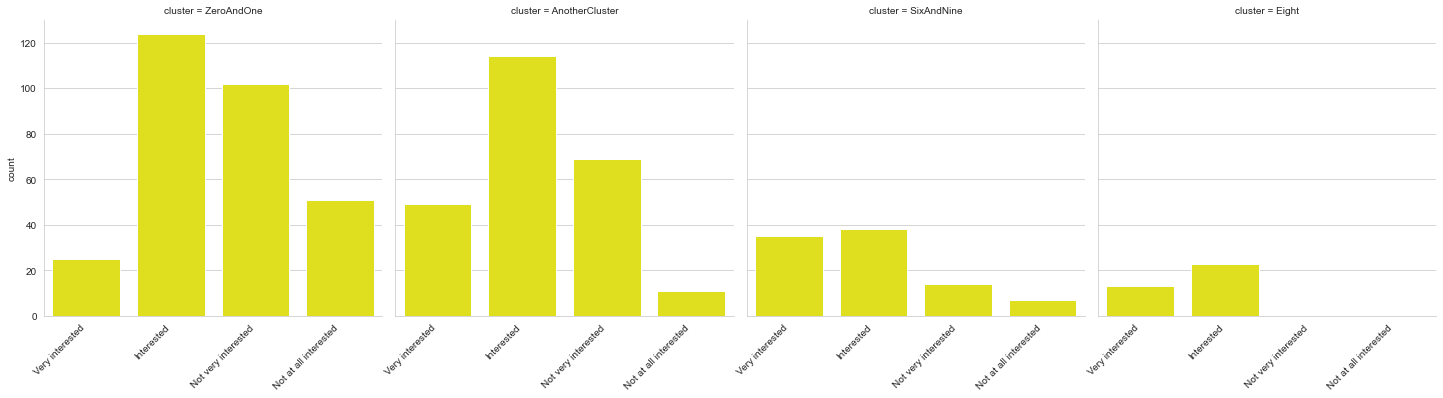

In [125]:
base_df["cluster"] = base_df["labels"].apply(cluster_labeller)
g = sns.catplot(interest_col, col="cluster", 
            col_wrap=4, data=base_df, kind="count", 
            color = "yellow", order = interest_order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.set_xlabel("")

In [126]:
logreg_interest_target =  1 - base_df[interest_col].str.contains("Not").astype(int)

In [127]:
logreg_interest_target.value_counts()

1    421
0    254
Name: How interested would you be in this type of solution as a whole?, dtype: int64

This was the only way I can get the logistic regression to converge....

In [142]:
high_var_columns = logreg_feats.var()[logreg_feats.var() > 0.13].index.tolist()

In [169]:
high_var_columns

['is_multinational',
 'is_executive',
 'is_male',
 'empFunc_Operations',
 'bizSize_1000-10,000 employees',
 'bizSize_250-1000 employees',
 'bizSize_50-250 employees',
 'buildCapability_I want my team to learn and adopt new ways of working',
 'buildCapability_I want to better prepare my team to deliver on our strategic goals',
 'bizStrategy_Deliver value to customers',
 'budgetCategory_IT',
 'budgetCategory_Learning and Development',
 'purchaseRole_I’d approve the purchase for my team',
 'purchaseRole_I’d make a request or recommendation to senior management',
 'empAge_30-39',
 'empAge_40-49',
 'empAge_50-59',
 'empAge_60+',
 'manageSituation_I manage a single department within my organization',
 'manageSituation_I manage more than one department within my organization',
 'manageSituation_I manage my organization',
 'edLevel_Master’s',
 'edLevel_Undergraduate',
 'salaryRange_$75,000 - 99,999',
 'directReports_10+',
 'directReports_2-5',
 'directReports_6-10',
 'region_Midwest',
 'region

In [128]:
logreg_feats = reg_df[base_feat_cols]

In [129]:
logreg_feats = sm.add_constant(logreg_feats)

In [155]:
logreg_interest_target.rename("y", inplace = True)

0      0
1      0
2      0
3      1
4      0
      ..
670    0
671    0
672    0
673    0
674    0
Name: y, Length: 675, dtype: int64

In [174]:
logreg_interest_model = sm.Logit(logreg_interest_target, sm.add_constant(logreg_feats[high_var_columns]))

In [175]:
logreg_interest_results = logreg_interest_model.fit(method = "bfgs")

         Current function value: 0.172651
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/rweijer/.pyenv/versions/3.6.10/envs/academy-survey/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [176]:
print(logreg_interest_results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  675
Model:                          Logit   Df Residuals:                      643
Method:                           MLE   Df Model:                           31
Date:                Thu, 02 Jul 2020   Pseudo R-squ.:                  0.7393
Time:                        16:29:01   Log-Likelihood:                -116.54
converged:                      False   LL-Null:                       -447.00
Covariance Type:            nonrobust   LLR p-value:                3.197e-119
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                             

In [159]:
logreg_interest_results.pred_table()

array([[253.,   1.],
       [ 11., 410.]])

In [160]:
would_buy_cols = [c for c in base_df.columns if "Would you invest in the next year" in c]

In [161]:
would_buy_cols

['Would you invest in the next year in a solution with the following benefits? - Easily communicating a new process to leadership',
 'Would you invest in the next year in a solution with the following benefits? - Setting up a new process for the team to lean on',
 'Would you invest in the next year in a solution with the following benefits? - Getting the process started fast',
 'Would you invest in the next year in a solution with the following benefits? - Consistently delivering value to customers',
 'Would you invest in the next year in a solution with the following benefits? - Focusing the team with a concrete time bound plan',
 'Would you invest in the next year in a solution with the following benefits? - Solving hard challenges creatively',
 'Would you invest in the next year in a solution with the following benefits? - Assessing teams’ strengths and growth areas',
 'Would you invest in the next year in a solution with the following benefits? - Receiving recommendations for tools

In [162]:
base_df[would_buy_cols].head(5)

,Would you invest in the next year in a solution with the following benefits? - Easily communicating a new process to leadership,Would you invest in the next year in a solution with the following benefits? - Setting up a new process for the team to lean on,Would you invest in the next year in a solution with the following benefits? - Getting the process started fast,Would you invest in the next year in a solution with the following benefits? - Consistently delivering value to customers,Would you invest in the next year in a solution with the following benefits? - Focusing the team with a concrete time bound plan,Would you invest in the next year in a solution with the following benefits? - Solving hard challenges creatively,Would you invest in the next year in a solution with the following benefits? - Assessing teams’ strengths and growth areas,Would you invest in the next year in a solution with the following benefits? - Receiving recommendations for tools and methods,Would you invest in the next year in a solution with the following benefits? - Seeing how teams are collaborating,Would you invest in the next year in a solution with the following benefits? - Learning new skills on the job,Would you invest in the next year in a solution with the following benefits? - Scaling the process across the organization
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Yes,NaN,NaN,Yes,Yes,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
would_invest_df = base_df[would_buy_cols].fillna("No")

In [166]:
for col in would_buy_cols:
    would_invest_df[col] = would_invest_df[col].apply(lambda v: 1 if v == "Yes" else 0)

In [167]:
would_invest_df.sum()

Would you invest in the next year in a solution with the following benefits? - Easily communicating a new process to leadership      93
Would you invest in the next year in a solution with the following benefits? - Setting up a new process for the team to lean on      73
Would you invest in the next year in a solution with the following benefits? - Getting the process started fast                      78
Would you invest in the next year in a solution with the following benefits? - Consistently delivering value to customers           125
Would you invest in the next year in a solution with the following benefits? - Focusing the team with a concrete time bound plan     95
Would you invest in the next year in a solution with the following benefits? - Solving hard challenges creatively                   100
Would you invest in the next year in a solution with the following benefits? - Assessing teams’ strengths and growth areas          111
Would you invest in the next year in a solution 

In [168]:
would_invest_df.max(axis = 1).describe()

count    675.000000
mean       0.585185
std        0.493055
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64

In [177]:
would_invest_df.max(axis = 1).sum()

395

In [178]:
would_invest_target = would_invest_df.max(axis = 1).rename("y")

In [179]:
would_invest_target.describe()

count    675.000000
mean       0.585185
std        0.493055
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: y, dtype: float64

In [180]:
logreg_feats = sm.add_constant(logreg_feats)

In [186]:
logreg_invest_model = sm.Logit(would_invest_target, sm.add_constant(logreg_feats[high_var_columns]))

In [187]:
logreg_invest_res = logreg_invest_model.fit(method = "bfgs")

         Current function value: 0.253562
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/rweijer/.pyenv/versions/3.6.10/envs/academy-survey/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [188]:
print(logreg_invest_res.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  675
Model:                          Logit   Df Residuals:                      643
Method:                           MLE   Df Model:                           31
Date:                Thu, 02 Jul 2020   Pseudo R-squ.:                  0.6263
Time:                        16:35:52   Log-Likelihood:                -171.15
converged:                      False   LL-Null:                       -458.03
Covariance Type:            nonrobust   LLR p-value:                3.513e-101
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                             